# Data Cleaning & Outlier Handling Pipeline

Comprehensive cleaning pipeline for demand forecasting data with outlier detection and replacement.

## Features

✅ Load and validate data  
✅ Remove duplicate rows  
✅ Filter data by date cutoff  
✅ Detect and report missing values  
✅ Fill missing values (week-back, day-back, or forward-fill)  
✅ Detect and replace outliers using Z-score method  
✅ Validate value ranges  
✅ Export to CSV or Excel  

## Quick Start

1. **Update Configuration** in Cell 3:
   - `INPUT_FILE`: CSV file to clean
   - `CUTOFF_DATE`: Filter dates after this value
   - `FILL_METHOD`: "week_back", "day_back", or "ffill"
   - `HANDLE_OUTLIERS`: Enable/disable outlier replacement
   - `OUTPUT_FORMAT`: "csv" or "excel"

2. **Run Cell 3** to execute the full pipeline
3. Output saved as `{filename}_cleaned.csv` (or .xlsx)

## Configuration Options

```python
# Fill missing values with data from one week prior
FILL_METHOD = "week_back"

# Or use one day prior
FILL_METHOD = "day_back"

# Or forward-fill
FILL_METHOD = "ffill"

# Outlier detection threshold
OUTLIER_THRESHOLD = 3

# Export format
OUTPUT_FORMAT = "excel"
```

## Processing Steps

1. **Load** - Parse CSV with datetime  
2. **Deduplicate** - Remove duplicate rows  
3. **Filter** - Keep data before cutoff  
4. **Check Missing** - Identify gaps  
5. **Fill Missing** - Use historical data  
6. **Handle Outliers** - Replace abnormal values  
7. **Validate** - Check value ranges  
8. **Save** - Export cleaned data


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ============================================================================
# CONFIGURATION
# ============================================================================

INPUT_FILE = "2026_proper_data.csv"          # Input CSV file
CUTOFF_DATE = "2027-02-01 00:00:00"             # Filter dates before this cutoff
REMOVE_DUPLICATES = True                         # Remove duplicate rows
FILL_METHOD = "week_back"                       # "week_back" (7 days), "day_back" (1 day), or "ffill"
HANDLE_OUTLIERS = False                          # Replace outliers with previous valid value
OUTLIER_THRESHOLD = 3                           # Z-score threshold for outliers
VALUE_RANGES = {                                # Valid value ranges by column (optional)
    "default": (0, 10000)                       # Default range for numeric columns
}
OUTPUT_FILE = None                              # Auto-generated if None
OUTPUT_FORMAT = "csv"                           # "csv" or "excel"

# Columns to apply special handling
DEMAND_COLUMNS = [
    "TPCODL Demand",
    "TPWODL Demand",
    "TPNODL Demand",
    "TPSOSDL Demand",
    "Total Demand (as recorded)"
]

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def load_data(file_path):
    """Load CSV file with proper datetime parsing (handles mixed formats)."""
    print(f"📂 Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Show sample timestamps to diagnose format
    print(f"   Sample timestamps:")
    print(f"   {df['Timestamp'].head(3).values}")
    
    # Try to parse with mixed format detection
    try:
        # Try YYYY-MM-DD format first (standard ISO)
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='ISO8601', errors="coerce")
        
        # If that doesn't work well, fall back to mixed format with dayfirst
        if df["Timestamp"].isna().sum() > len(df) * 0.5:  # More than 50% failed
            print(f"   ⚠️  ISO8601 format had too many failures, trying mixed format...")
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], 
                                            format='mixed', 
                                            dayfirst=True, 
                                            errors="coerce")
        
        # Final fallback: standard inference with dayfirst
        if df["Timestamp"].isna().sum() > len(df) * 0.5:
            print(f"   ⚠️  Mixed format had failures, trying standard inference...")
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], 
                                            dayfirst=True, 
                                            errors="coerce")
    except Exception as e:
        print(f"   ⚠️  Error parsing timestamps: {e}")
        print(f"   Trying with dayfirst=True...")
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], 
                                        dayfirst=True, 
                                        errors="coerce")
    
    # Report parsing results
    failed = df["Timestamp"].isna().sum()
    if failed > 0:
        print(f"   ⚠️  WARNING: {failed} timestamps failed to parse")
        print(f"   Failed samples: {df[df['Timestamp'].isna()]['Timestamp'].head(3).values}")
    else:
        print(f"   ✅ All timestamps parsed successfully")
    
    print(f"✅ Data loaded. Shape: {df.shape}")
    print(f"   Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
    return df

def remove_duplicates(df):
    """Remove duplicate rows."""
    initial_len = len(df)
    df = df.drop_duplicates()
    removed = initial_len - len(df)
    
    if removed > 0:
        print(f"🗑️  Removed {removed} duplicate rows")
    else:
        print(f"✅ No duplicates found")
    
    return df

def filter_by_date(df, cutoff_date):
    """Filter data before cutoff date."""
    cutoff = pd.Timestamp(cutoff_date)
    df_filtered = df[df["Timestamp"] < cutoff]
    removed = len(df) - len(df_filtered)
    
    if removed > 0:
        print(f"🔍 Filtered {removed} rows after {cutoff_date}")
    else:
        print(f"✅ No rows filtered by date")
    
    return df_filtered

def check_missing_values(df):
    """Check and report missing values."""
    missing = df.isna().sum()
    missing = missing[missing > 0]
    
    if len(missing) > 0:
        print(f"⚠️  Missing values detected:")
        for col, count in missing.items():
            pct = (count / len(df)) * 100
            print(f"   {col}: {count} ({pct:.2f}%)")
        return missing
    else:
        print(f"✅ No missing values")
        return missing

def fill_missing_values(df, method="week_back"):
    """
    Fill missing values using specified method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with sorted Timestamp
    method : str
        - "week_back": Use value from 7 days ago (96*7 intervals for 15-min data)
        - "day_back": Use value from 1 day ago (96 intervals)
        - "ffill": Forward fill
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with filled values
    """
    print(f"🔧 Filling missing values using '{method}' method...")
    
    df = df.sort_values("Timestamp").reset_index(drop=True)
    
    if method == "week_back":
        shift_periods = 7 * 96  # 7 days * 96 intervals (15-min)
    elif method == "day_back":
        shift_periods = 96     # 1 day * 96 intervals
    else:
        shift_periods = 1
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].shift(shift_periods))
    
    remaining_missing = df[numeric_cols].isna().sum().sum()
    print(f"✅ Filled missing values. Remaining NaNs: {remaining_missing}")
    
    return df

def handle_outliers(df, columns, threshold=3):
    """
    Replace outliers with previous week's value using Z-score method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    columns : list
        Columns to check for outliers
    threshold : float
        Z-score threshold (default: 3)
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with outliers replaced
    """
    print(f"🎯 Handling outliers (Z-score threshold: {threshold})...")
    
    df = df.copy()
    
    for col in columns:
        if col not in df.columns:
            continue
        
        # Convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Calculate Z-scores
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outlier_mask = z_scores > threshold
        
        # Replace outliers with week-back value
        outlier_indices = df[outlier_mask].index
        for idx in outlier_indices:
            back_idx = idx - (7 * 96)  # 7 days back
            if back_idx >= 0:
                df.loc[idx, col] = df.loc[back_idx, col]
        
        if outlier_mask.sum() > 0:
            print(f"   {col}: Replaced {outlier_mask.sum()} outliers")
    
    print("✅ Outlier handling complete")
    return df

def check_value_ranges(df, ranges):
    """
    Check value ranges and report issues.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    ranges : dict
        Range dict with "default" or column-specific ranges
    
    Returns:
    --------
    None (prints report)
    """
    print("\n📊 VALUE RANGE CHECK")
    print("=" * 60)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    default_min, default_max = ranges.get("default", (0, 10000))
    
    for col in numeric_cols:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min < default_min or col_max > default_max:
            print(f"⚠️  {col}: Min={col_min:.2f}, Max={col_max:.2f} (Expected: {default_min}-{default_max})")
        else:
            print(f"✅ {col}: Min={col_min:.2f}, Max={col_max:.2f}")

def save_data(df, output_path=None, input_file="input.csv", format="csv"):
    """Save processed data to file."""
    if output_path is None:
        stem = Path(input_file).stem
        ext = "xlsx" if format.lower() == "excel" else "csv"
        output_path = f"{stem}_cleaned.{ext}"
    
    if format.lower() == "excel":
        df.to_excel(output_path, index=False)
    else:
        df.to_csv(output_path, index=False)
    
    print(f"💾 Data saved to: {output_path}")
    return output_path

# ============================================================================
# MAIN PROCESSING PIPELINE
# ============================================================================

# Step 1: Load data
df = load_data(INPUT_FILE)

# Step 2: Remove duplicates
if REMOVE_DUPLICATES:
    df = remove_duplicates(df)

# Step 3: Filter by date
df = filter_by_date(df, CUTOFF_DATE)

# Step 4: Check for missing values
missing = check_missing_values(df)

# Step 5: Fill missing values if any
if len(missing) > 0:
    df = fill_missing_values(df, FILL_METHOD)

# Step 6: Handle outliers
if HANDLE_OUTLIERS and len(DEMAND_COLUMNS) > 0:
    df = handle_outliers(df, DEMAND_COLUMNS, OUTLIER_THRESHOLD)

# Step 7: Check value ranges
check_value_ranges(df, VALUE_RANGES)

# Step 8: Save cleaned data
output_file = save_data(df, OUTPUT_FILE, INPUT_FILE, OUTPUT_FORMAT)

# Display summary
print(f"\n✨ Data cleaning complete!")
print(f"Final shape: {df.shape}")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")


📂 Loading data from 2026_proper_data.csv...
   Sample timestamps:
   ['2017-01-01 00:00:00' '2017-01-01 00:15:00' '2017-01-01 00:30:00']
   ✅ All timestamps parsed successfully
✅ Data loaded. Shape: (316933, 6)
   Date range: 2017-01-01 00:00:00 to 2026-01-15 09:00:00
✅ No duplicates found
✅ No rows filtered by date
✅ No missing values

📊 VALUE RANGE CHECK
✅ TPCODL Demand: Min=231.57, Max=2480.00
✅ TPWODL Demand: Min=248.16, Max=3362.74
✅ TPNODL Demand: Min=254.22, Max=1614.00
✅ TPSOSDL Demand: Min=166.47, Max=755.15
✅ Total Demand (as recorded): Min=1324.93, Max=7336.00
💾 Data saved to: 2026_proper_data_cleaned.csv

✨ Data cleaning complete!
Final shape: (316933, 6)
Date range: 2017-01-01 00:00:00 to 2026-01-15 09:00:00



📊 CLEANED DATA SUMMARY

Shape: (316933, 6)

Data types:
Timestamp                     datetime64[ns]
TPCODL Demand                        float64
TPWODL Demand                        float64
TPNODL Demand                        float64
TPSOSDL Demand                       float64
Total Demand (as recorded)           float64
dtype: object

Descriptive statistics:
                           Timestamp  TPCODL Demand  TPWODL Demand  \
count                         316933  316933.000000  316933.000000   
mean   2021-07-09 16:29:59.999999488    1142.281915    1461.656414   
min              2017-01-01 00:00:00     231.565067     248.161080   
25%              2019-04-06 08:15:00     942.667420    1006.416053   
50%              2021-07-09 16:30:00    1105.532747    1449.000000   
75%              2023-10-13 00:45:00    1314.000000    1825.796973   
max              2026-01-15 09:00:00    2480.000000    3362.739960   
std                              NaN     296.284210     502.813812   

   

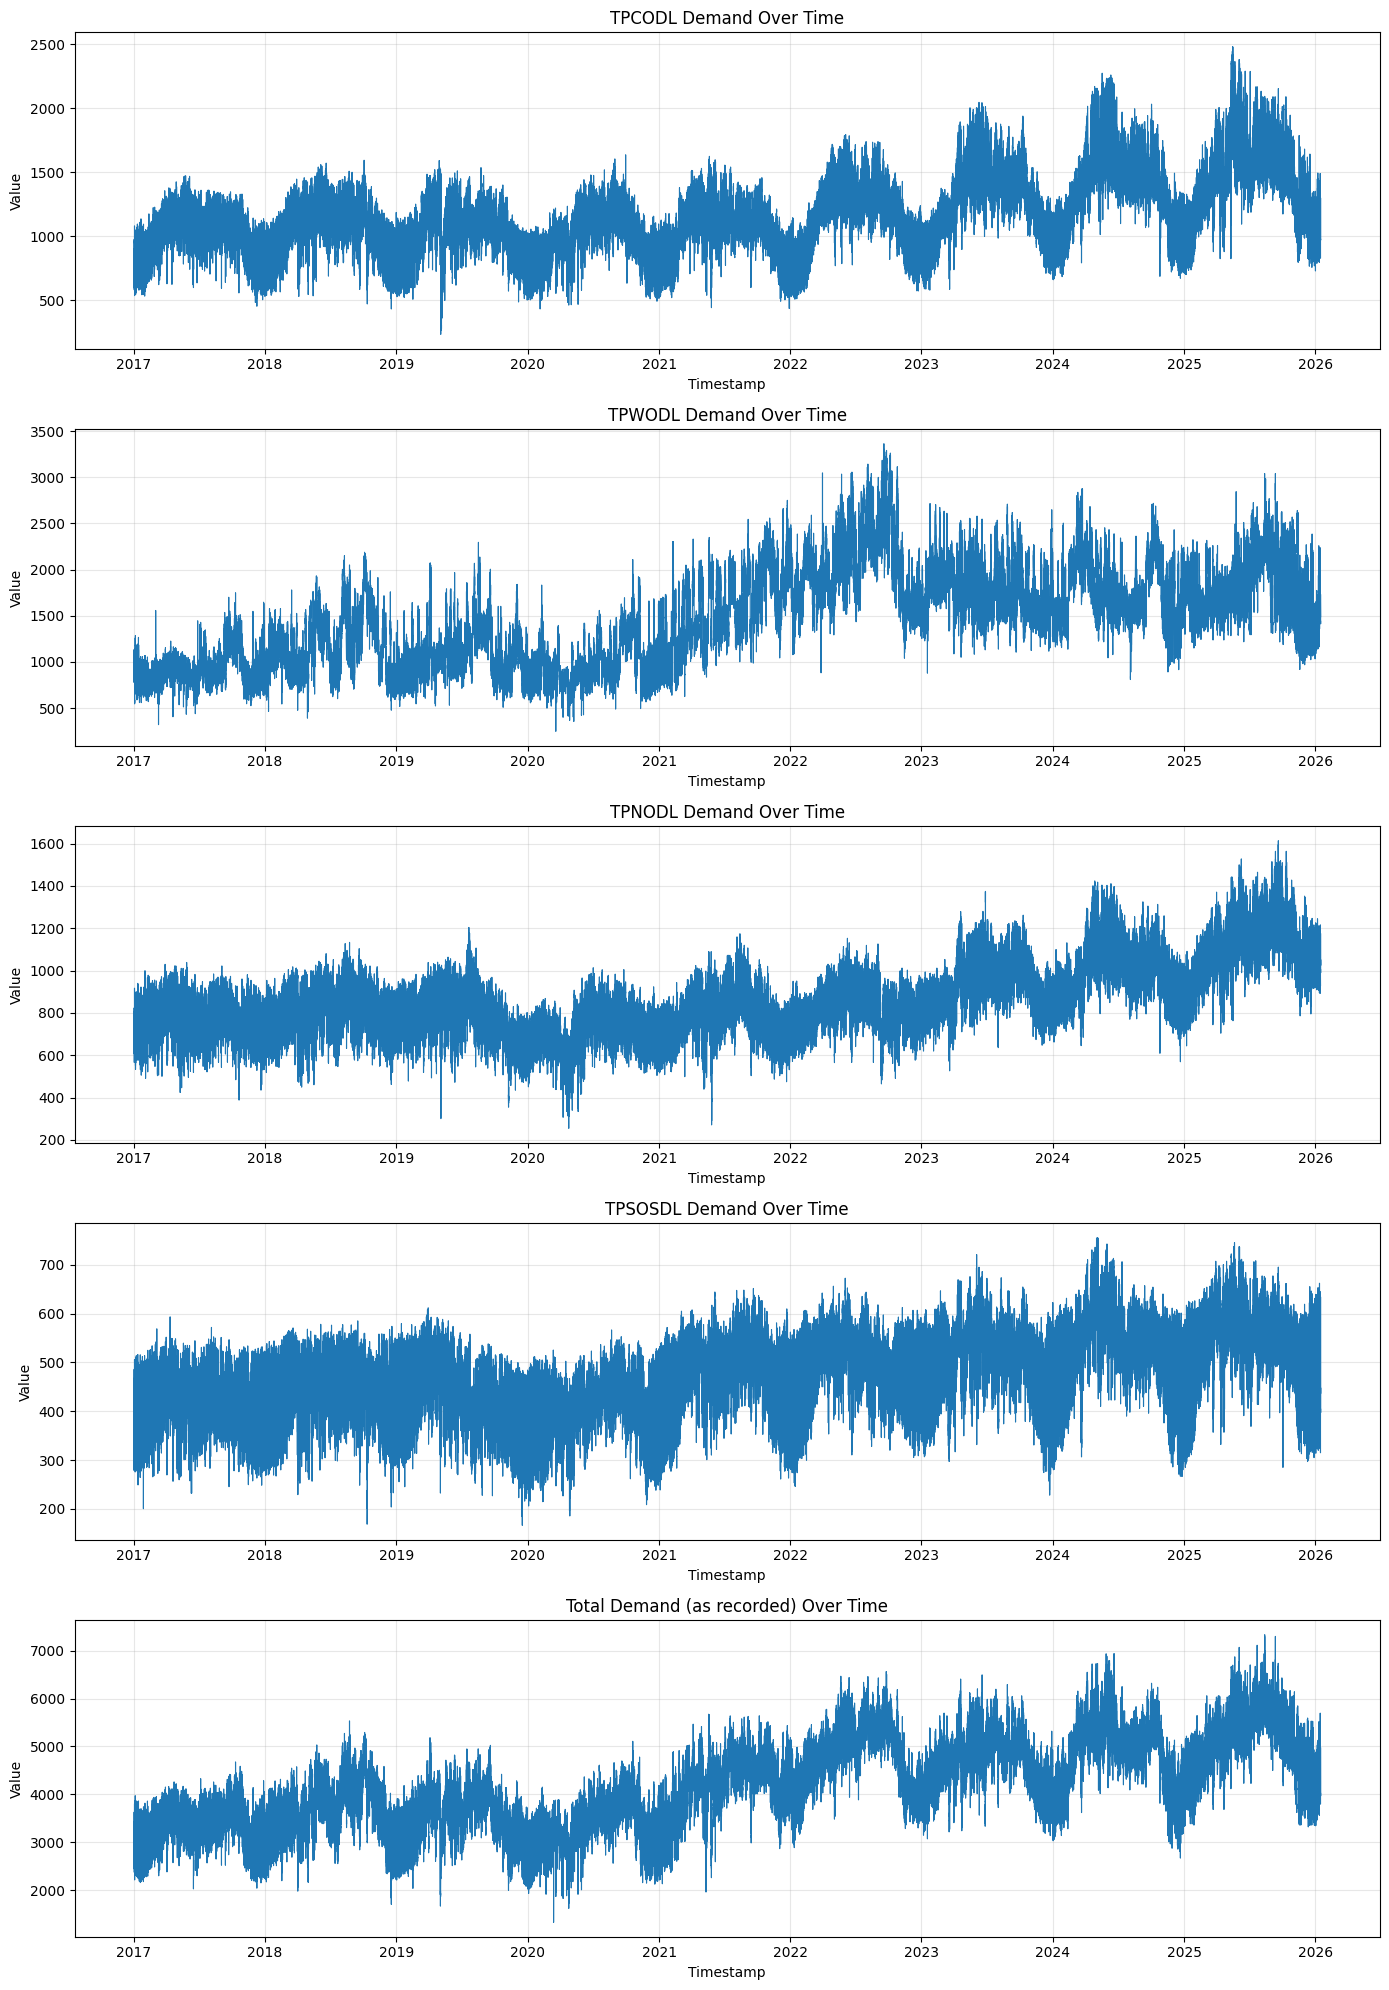

In [50]:
# ============================================================================
# OPTIONAL: Summary statistics and visualizations
# ============================================================================

print("\n📊 CLEANED DATA SUMMARY")
print("=" * 70)
print(f"\nShape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nDescriptive statistics:")
print(df.describe())

# Plot demand columns
demand_cols = [col for col in df.columns if "Demand" in col]
if demand_cols:
    fig, axes = plt.subplots(len(demand_cols), 1, figsize=(14, 4*len(demand_cols)))
    if len(demand_cols) == 1:
        axes = [axes]
    
    for ax, col in zip(axes, demand_cols):
        ax.plot(df["Timestamp"], df[col], linewidth=0.8)
        ax.set_title(f"{col} Over Time")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Value")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
